In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys


from scipy.stats import pearsonr


# sklearn ML models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


/Users/liugrp_m/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df = pd.read_csv('../01-database-preprocessing-1203dp-to-1115dp/raw/atom_number_wH_sort_1115-backbone-correction-newSMILES.csv')
df.head()

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,HOMO(eV),LUMO(eV)
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,-5.20,-3.27
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,-4.90,-3.08
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,-5.34,-3.58
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,-5.15,-3.23
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,-5.11,-3.22


# experimental values

In [3]:
df_exp = df['bandgap(eV)']
df_exp

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1110    1.68
1111    1.65
1112    1.66
1113    1.52
1114    1.73
Name: bandgap(eV), Length: 1115, dtype: float64

# DFT gap from oligomer

In [4]:
df = pd.read_csv('./DFT/scf-6-31gs.csv')
scf_oligomer = df[['HOMO-LUMO(eV)']]
scf_oligomer

,HOMO-LUMO(eV)
0,2.78726
1,2.72032
2,3.19979
3,2.69964
4,2.66372
...,...
1110,1.93038
1111,1.93065
1112,2.04439
1113,1.94561


# DFT gap from monomer

In [6]:
df = pd.read_csv('../06-DFT-monomer/DFT/opt-6-31gs.csv')
scf_monomer = df[['HOMO-LUMO(eV)']]
scf_monomer

,HOMO-LUMO(eV)
0,5.62269
1,5.54514
2,5.07656
3,3.98864
4,3.35816
...,...
1110,1.94915
1111,2.21365
1112,1.97283
1113,1.86044


# drop sp3-N polymers + donor-692

In [7]:
sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [8]:
df_dft_oligomer = scf_oligomer[~scf_oligomer.index.isin(drop_list)].reset_index(drop=True)
df_dft_monomer = scf_monomer[~scf_monomer.index.isin(drop_list)].reset_index(drop=True)
df_exp = df_exp[~df_exp.index.isin(drop_list)].reset_index(drop=True)

# Linear fitting

In [9]:
y = df_exp
y

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1091    1.68
1092    1.65
1093    1.66
1094    1.52
1095    1.73
Name: bandgap(eV), Length: 1096, dtype: float64

In [10]:
X_oligomer = df_dft_oligomer
model = LinearRegression()
model.fit(X_oligomer,y)
y_oligomer = model.predict(X_oligomer)
a_oligomer  = model.intercept_ #截距 
b_oligomer = model.coef_ #回归系数
score_oligomer = model.score(X_oligomer,y) 

In [11]:
X_monomer = df_dft_monomer
model = LinearRegression()
model.fit(X_monomer,y)
y_monomer = model.predict(X_monomer)
a_monomer  = model.intercept_ #截距 
b_monomer = model.coef_ #回归系数
score_monomer = model.score(X_monomer,y) 

In [12]:
y_oligomer.max(), y_monomer.max()

(2.578202075825047, 2.167137454694013)

In [13]:
y_oligomer.min(), y_monomer.min()

(0.9695367524811793, 1.3987788458853154)

## c. stack 2 figures: exp gap vs fitted gap

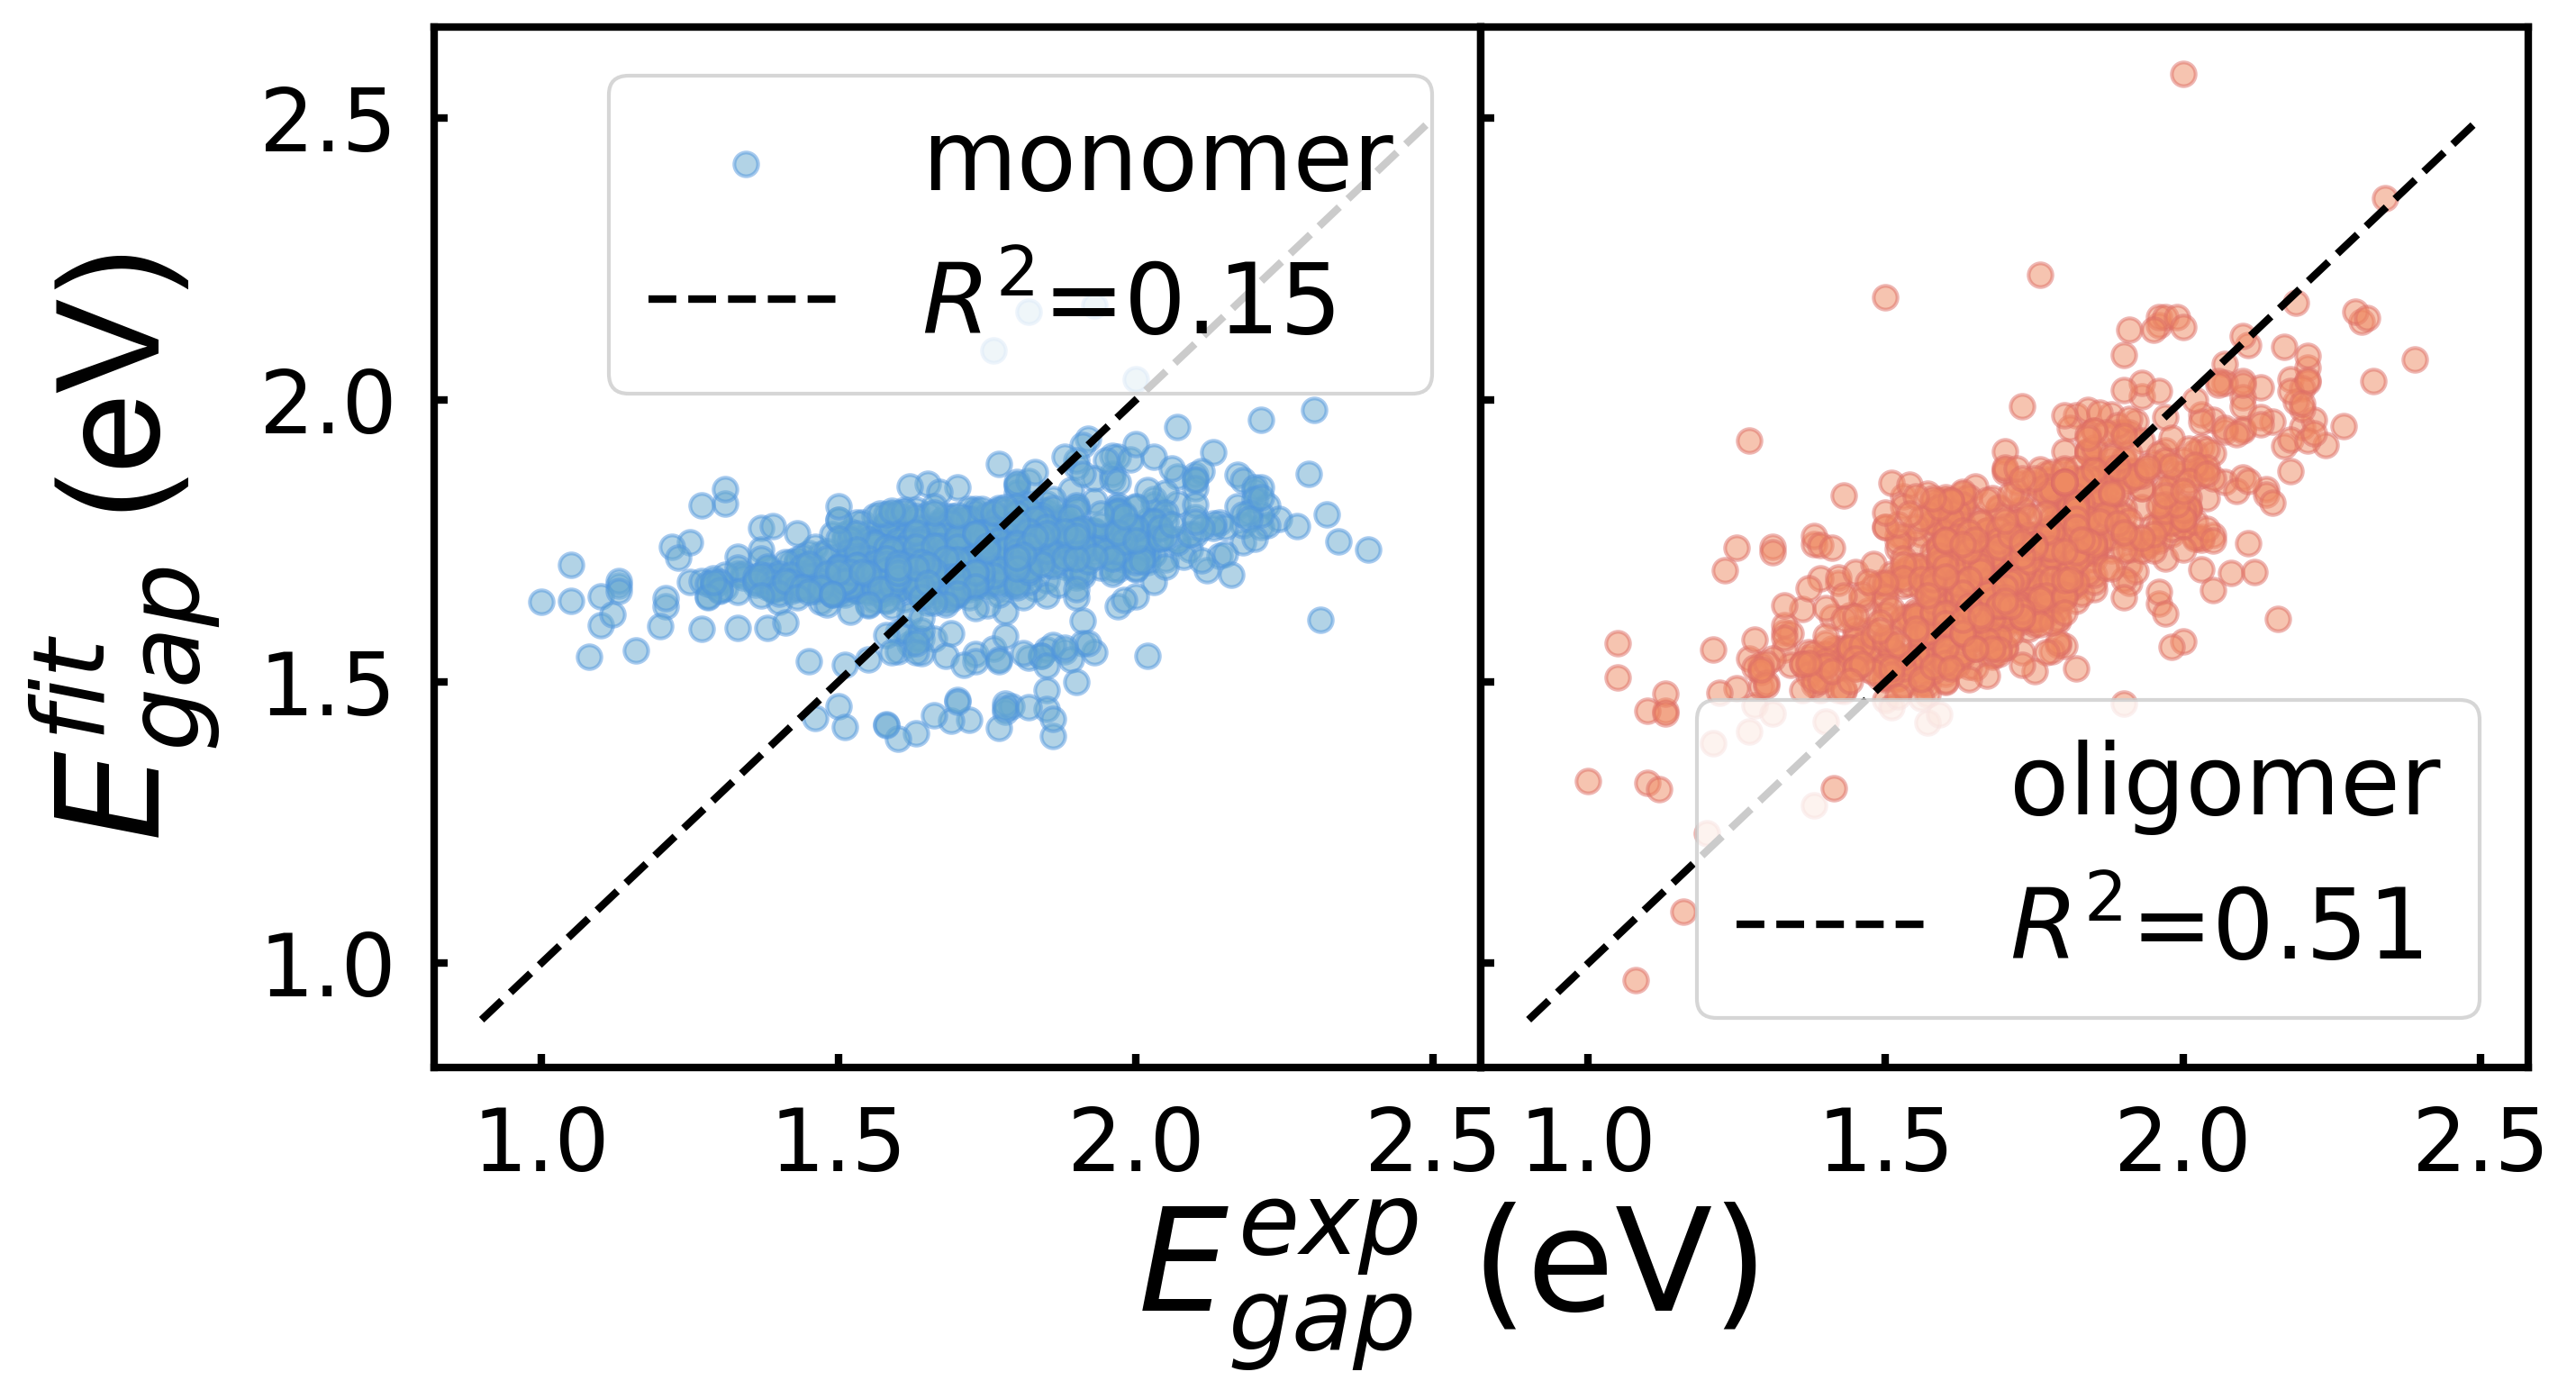

In [16]:
xmin=0.9
xmax=2.5
ticks=[1,1.5,2,2.5]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300, sharey=True, gridspec_kw={'wspace': 0})

i=0
axes[i].scatter(y, y_monomer, color ='#67a9cf', s=40, alpha=0.5, edgecolor='#5096DE', label='monomer', linewidth=1)
axes[i].plot((xmin,xmax), (xmin, xmax), ls='--', c='black', linewidth=2.0, label=f"$R^2$={round(score_monomer,2)}")
axes[i].legend(fontsize=26)
for spine in axes[i].spines.values():
    spine.set_linewidth(2)


axes[i].set_xticks(ticks)
axes[i].set_yticks(ticks)
axes[i].tick_params(direction='in', width=2)
axes[i].tick_params(axis='x', labelsize=23, pad=10)
axes[i].tick_params(axis='y', labelsize=23, pad=10)
axes[i].set_ylabel('$E_{gap}^{fit}$ (eV)', fontsize=38, font="arial", labelpad=10)
    
i=1
axes[i].scatter(y, y_oligomer, color ='#ef8a62', s=40, alpha=0.5,edgecolor='#DE6E66', label='oligomer', linewidth=1)
axes[i].plot((xmin,xmax), (xmin,xmax), ls='--', c='black', linewidth=2.0, label=f"$R^2$={round(score_oligomer,2)}")
axes[i].legend(fontsize=26)
for spine in axes[i].spines.values():
    spine.set_linewidth(2)
    
axes[i].set_xticks(ticks)
axes[i].set_yticks(ticks)
axes[i].tick_params(direction='in', width=2)
axes[i].tick_params(axis='x', labelsize=23, pad=10)
axes[i].tick_params(axis='y', labelsize=23, pad=10)

fig.text(0.5, -0.07, '$E_{gap}^{exp}$ (eV)', ha='center', fontsize=38)
plt.show()

## c. stack 2 figures

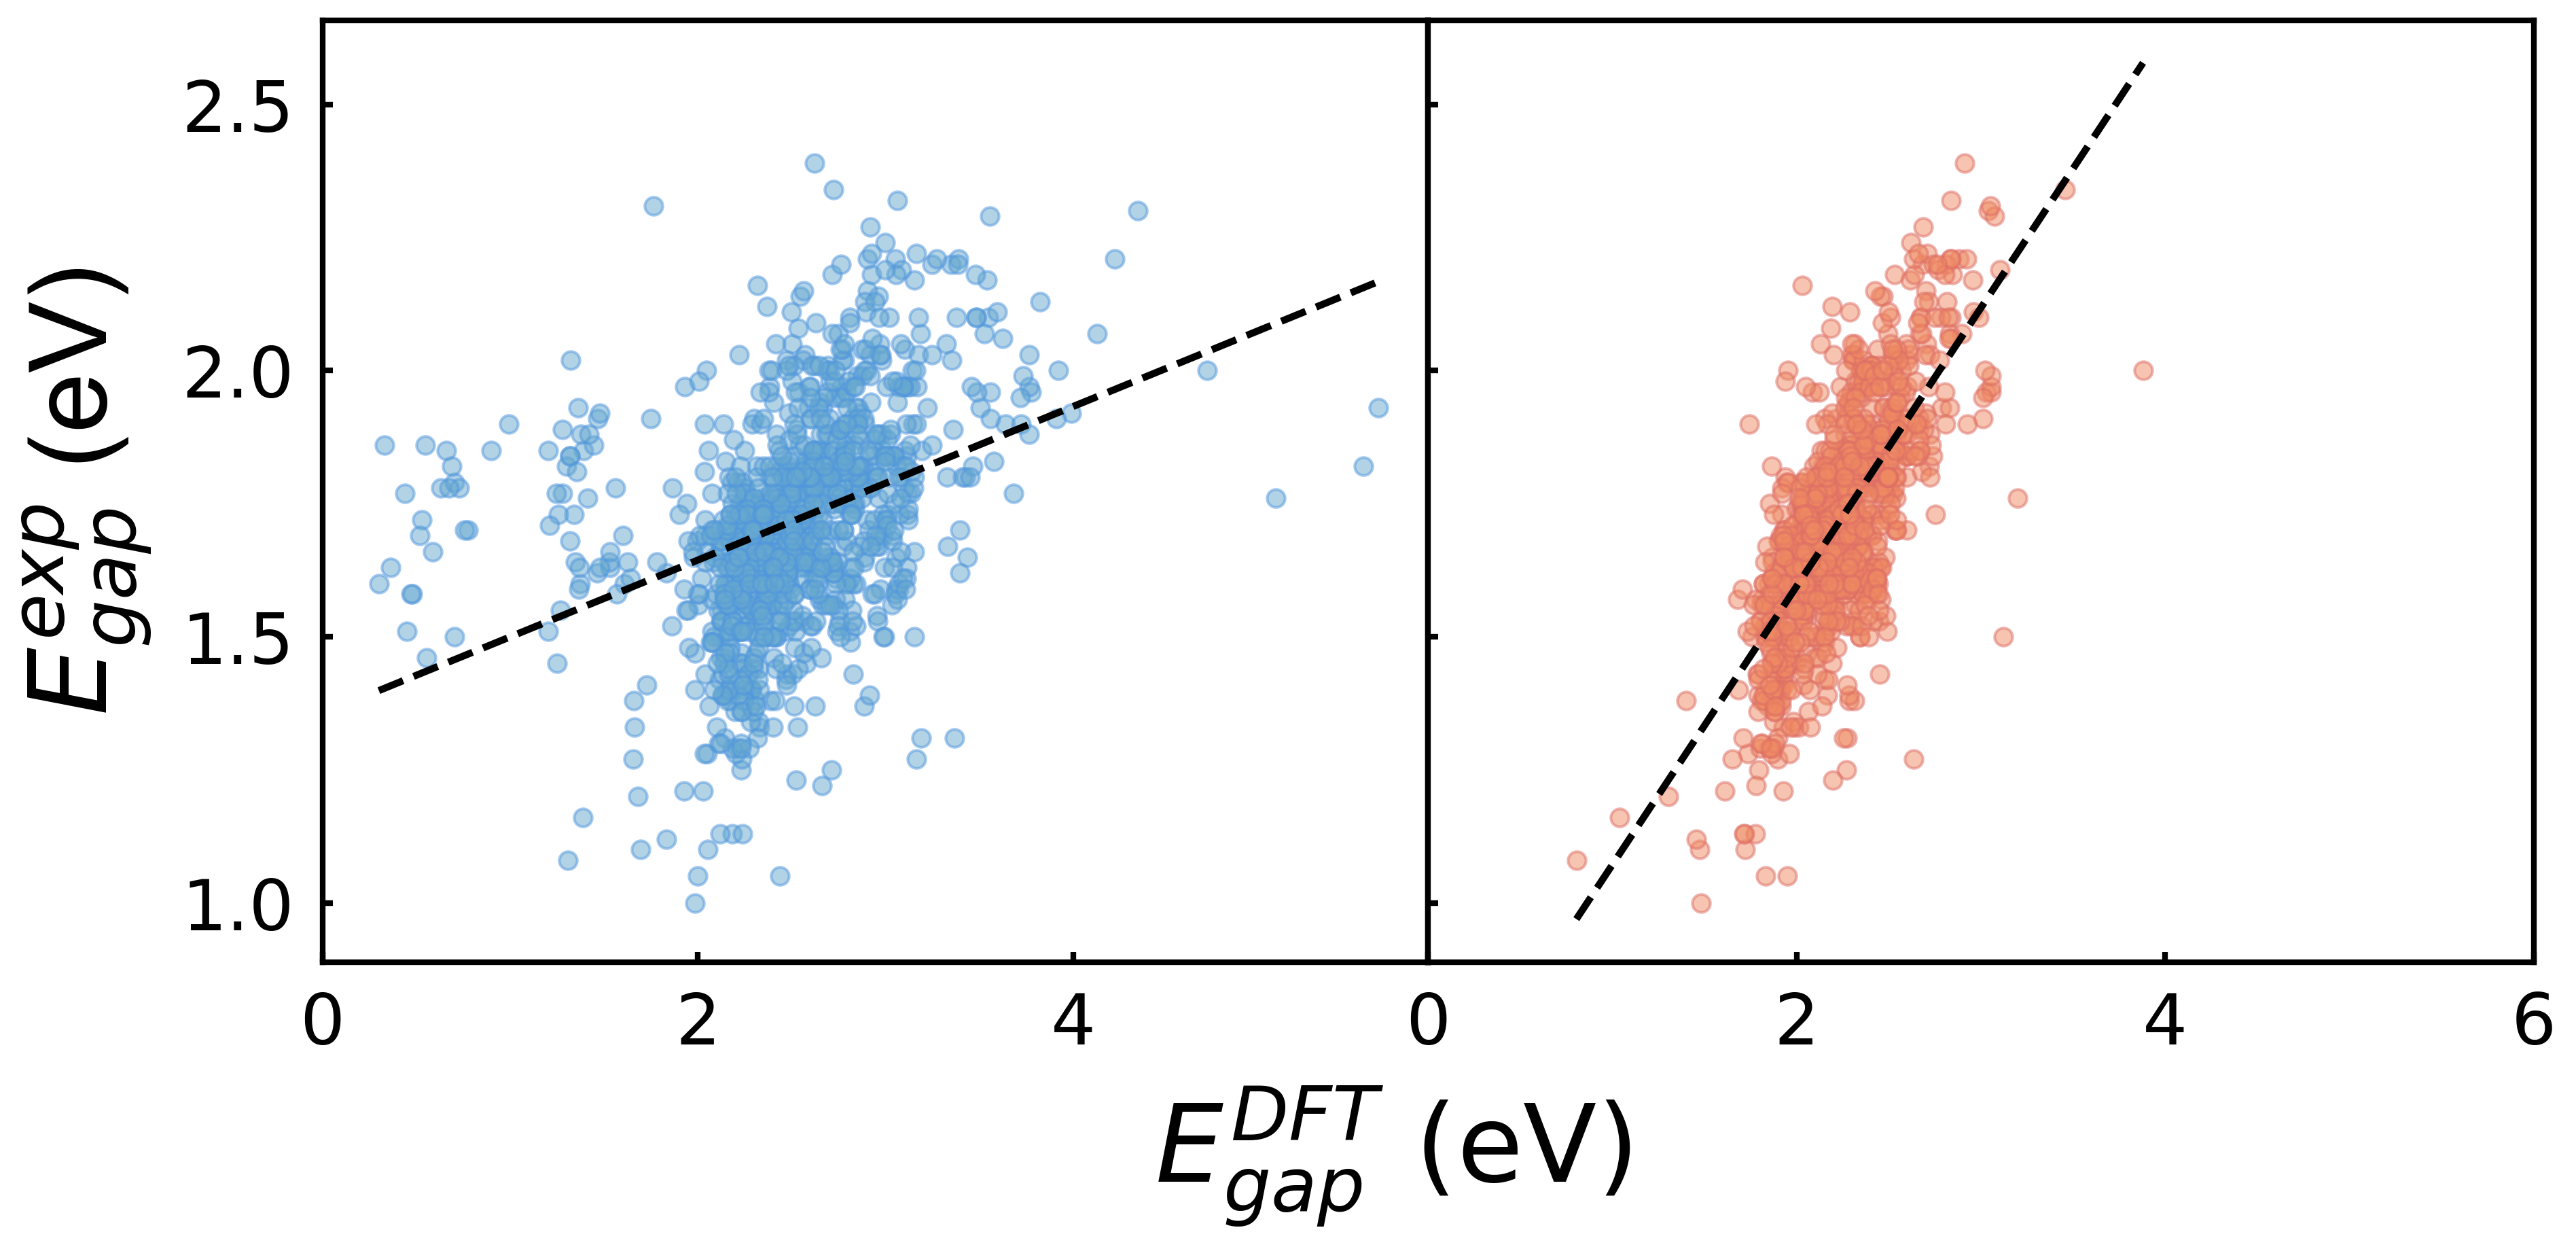

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300, sharey=True, gridspec_kw={'wspace': 0})

i=0
axes[i].scatter(X_monomer, y, color ='#67a9cf', s=40, alpha=0.5, edgecolor='#5096DE', label='monomer', linewidth=1)
xmax=X_monomer.max()
xmin=X_monomer.min()
ymax=b_monomer[0]*xmax+a_monomer
ymin=b_monomer[0]*xmin+a_monomer
axes[i].plot((xmin,xmax), (ymin,ymax), ls='--', c='black', linewidth=2.5, label=f"$R^2$={round(score_monomer,2)}")
# axes[i].legend(fontsize=26)
for spine in axes[i].spines.values():
    spine.set_linewidth(2)

xticks=[0,2,4]
yticks=[1,1.5,2,2.5]

axes[i].set_xticks(xticks)
axes[i].set_yticks(yticks)
axes[i].tick_params(direction='in', width=2)
axes[i].tick_params(axis='x', labelsize=25, pad=10)
axes[i].tick_params(axis='y', labelsize=25, pad=10)
axes[i].set_ylabel('$E_{gap}^{exp}$ (eV)', fontsize=38, font="arial", labelpad=10)
    
i=1
axes[i].scatter(X_oligomer, y, color ='#ef8a62', s=40, alpha=0.5,edgecolor='#DE6E66', label='oligomer', linewidth=1)
xmax=X_oligomer.max()
xmin=X_oligomer.min()
ymax=b_oligomer[0]*xmax+a_oligomer
ymin=b_oligomer[0]*xmin+a_oligomer
axes[i].plot((xmin,xmax), (ymin,ymax), ls='--', c='black', linewidth=2.5, label=f"$R^2$={round(score_oligomer,2)}")
# axes[i].legend(fontsize=26)
for spine in axes[i].spines.values():
    spine.set_linewidth(2)
    
xticks=[0,2,4,6]
yticks=[1,1.5,2,2.5]

axes[i].set_xticks(xticks)
axes[i].set_yticks(yticks)
axes[i].tick_params(direction='in', width=2)
axes[i].tick_params(axis='x', labelsize=25, pad=10)
axes[i].tick_params(axis='y', labelsize=25, pad=10)

fig.text(0.5, -0.07, '$E_{gap}^{DFT}$ (eV)', ha='center', fontsize=38)
plt.show()